# Zadanie 4: Użycie algorytmu Grovera do problemu znajdowania zbioru dominującego

**Gratulujemy dotrwania do finałowego zadania!**
Ostatnie zadanie jest zadaniem konkursowym, czyli koszt obwodu który stworzycie będzie miał bezpośredni wpływ na waszą pozycję w rankingu. Z tego powodu pomoc organizatorów zostanie ograniczona do minimum, głównie do rozwiązywania prostych problemów związanych z oprogramowaniem Qiskit, Pythonem bądź precyzowania reguł zadań.

Powodzenia w rozwiązaniu poniższego zadania!

# Zbiór dominujący

W poprzednim zadaniu implementowaliśmy algorytm Grovera do znajdowania optymalnego rozwiązania problemu Max-Cut. Innymi słowy, szukaliśmy takiego kolorowania, dla którego liczba krawędzi łączących wierzchołki pokolorowane na dwa różne kolory była możliwie duża.

Szukanie najmniejszego _zbioru dominującego_ (ang. *dominating set*) również polega na szukaniu kolorowania wierzchołków, jednak cel jest inny. Zbiorem dominującym nazywamy taki podzbiór wierzchołków, że każdy wierzchołek grafu jest w tym podzbiorze lub sąsiaduje z którymś z wierzchołków z tego podzbioru. Poniżej zaprezentowaliśmy kilka zbiorów dominujących (wyróżnionych kolorem czerwonym):

<img src="graphics/task4_good_examples.png" width=800/>

Zauważcie, że każdy wierzchołek jest pokolorowany na czerwono lub sąsiaduje z takim wierzchołkiem. Poniżej zaprezentowaliśmy przykłady kolorowania grafów nie dających zbioru dominującego.

<img src="graphics/task4_bad_examples.png" width=400/>

Wierzchołki wyróżnione niebieskim kwadratem nie są w zbiorze oraz nie sąsiadują z wierzchołkiem ze zbioru.

Problem znajdowania zbioru dominującego o najmniejszej liczbie wierzchołków jest trudnym problemem (wręcz NP-trudnym). Jednocześnie problem ten ma dość ważne zastosowanie w praktyce: wyobraźcie sobie, że wierzchołki grafu są powiązane z pewną lokalizacją w mieście i umieszczamy w nich urządzenia mierzące jakieś lokalne parametry (np. niech będą to stacje meteorologiczne). Chcemy, aby bieżące wyniki były przekazywane bezpośrednio do serwera, jednak zamiast wstawiać silny nadajnik przy każdej stacji (co jest kosztowne), możemy wstawić je jedynie przy pewnych wyróżnionych stacjach i przesyłać informacje z pozostałych stacji do sąsiadujących stacji z silnymi nadajnikami. Oczywiście, im mniejsza liczba silnych nadajników tym mniejszy koszt.

## Zadanie konkursowe

W ramach finałowego zadania należy znaleźć możliwe lokalizacje nadajników dla poniższej mapy stacji meteorologicznych. Pamiętaj, że stacja może przesyłać dane najdalej do nadajnika przy stacji, z którą sąsiaduje.

<img src="graphics/task4.png" width=400/>

Skądinąd wiemy, że wystarczy ustawić dokładnie trzy nadajniki, co więcej, minimum trzy nadajniki są potrzebne do rozwiązania problemu.

**Rozwiązanie musi spełniać szereg reguł**:

* Skonstruowany obwód nie może składać się z więcej niż 26 kubitów.
* Należy użyć algorytmu Grovera, który poznaliście w zadaniu drugim, z trzema iteracjami.
* Wynik pomiaru $1$ oznacza, że wierzchołek należy do zbioru dominującego, a wynik $0$, że nie należy.
* Zastosuj jedynie jeden 9-bitowy klasyczny rejestr `c`, w którym są zapisywane wyniki pomiaru. W tym celu możecie korzystać z wzorca poniżej.
* __Uwaga: można skorzystać z informacji, że szukamy położenia trzech nadajników, jednak jest to jedyna informacja dotycząca rozwiązania, z której można skorzystać__. W szczególności nie można implementować wyroczni poprzez wcześniejsze znalezienie rozwiązania klasycznymi metodami. **Pomocnicze pytania:** Czy algorytm który skonstruowałem/am będzie działał dla dowolnego grafu nieskierowanego, jeśli będę znał/a rozmiar zbioru dominującego (powinno być: **tak**)? Czy korzystam z jakichś nietypowych cech grafu (jest nieregularny, niedwudzielny itp.) (powinno być: **nie**)? Czy korzystam z wiedzy jakie jest rozwiązanie (powinno być: **nie**)? 
* Obwód kwantowy może składać się jedynie z dostępnych w Qiskit bramek kwantowych (`x`, `ccx`, `mct`, `z`, `u3`, etc.) oraz pomiarów. Nie można korzystać z operacji nie będących bramkami, typu `reset`, `c_if`, itp, oraz bramki `unitary`. Jeśli masz wątpliwości co do użytej bramki - zapytaj mentorów.
* Nie można korzystać z optymalizatorów do obwodów kwantowych opartych na uczeniu maszynowych bądź heurystycznych innych niż `transpile` użyty poniżej. W `transpile` poniżej nie można zmieniać argumentów.
* **Jako rozwiązanie należy wysłać plik `zadanie_4.json` wygenerowany przez `create_submission` oraz plik `zadanie_4.ipynb` wraz z odpowiednimi komentarzami opisującymi kroki algorytmu.**

<div class="alert alert-block alert-danger">
Symulowanie kwantowych obwodów na klasycznym komputerze jest dość czasochłonnym zadaniem - znajdowanie stanu kwantowego może zająć od kilkunastu sekund, do kilkunastu minut. Dlatego prosimy o cierpliwe czekanie na wynik obliczeń w przypadku wysyłania ich do symulatora IBM, gdyż umieszczenie kilku obliczeń jednocześnie na serwerze (szczególnie przy wielu użytkownikach) może bardzo szybko przeciążyć serwer.
</div>

**Skorzystaj z poniższego wzorca.**

### Funkcje pomocnicze

In [1]:
G = {
    0: [1, 6],
    1: [0, 7],
    2: [3, 7],
    3: [2, 8],
    4: [5, 8],
    5: [4, 6],
    6: [0, 5, 7, 8],
    7: [1, 2, 6, 8],
    8: [3, 4, 6, 7],
}

In [2]:
def validate_dominating_set(bitstring):
    invalid_nodes = []
    for v, edges in G.items():
        in_set = bool(int(bitstring[v]))
        if in_set:
            continue
        correct = False
        for edge in edges:
            neighbor_in_set = bool(int(bitstring[edge]))
            correct = correct or neighbor_in_set
        if not correct:
            invalid_nodes += [v]
    return invalid_nodes

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_solution(G, bitstring):
    invalid_nodes = validate_dominating_set(bitstring)
    graph = nx.Graph()

    for v, edges in G.items():
        for e in edges:
            graph.add_edges_from([(v, e)])


    colors = ['red' if bool(int(bitstring[node])) else ('lightblue' if node in invalid_nodes else 'white') for node in graph.nodes()]        

    pos = nx.spring_layout(graph)
    nx.draw(graph, pos)
    nx.draw_networkx_labels(graph, pos, font_size=20)
    nx.draw_networkx_nodes(graph, pos, node_color=colors, node_size=1000, edgecolors='black')
    plt.show()

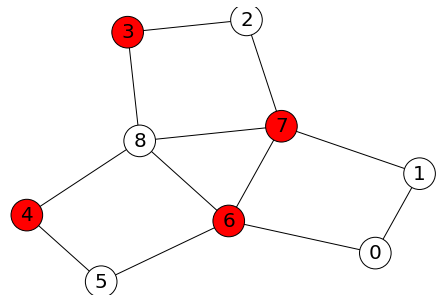

In [4]:
bitstring = '000110110'
visualize_solution(G, bitstring)

In [5]:
# Added only for circuit readibility. Disabled by default, as it affects the score negatively

barrier = False

In [6]:
def ccx(qc, a, b, t, simple=True):
    if simple:
        # Per https://qiskit.org/textbook/ch-gates/more-circuit-identities.html#1.-Making-a-Controlled-Z-from-a-CNOT-
        qc.ch(a,t)
        qc.cz(b,t)
        qc.ch(a,t)
    else:
        qc.ccx(a, b, t)

def half_adder(circ, a, b, c): #c musi być 0
    ccx(circ, a, b, c)
    circ.cx(a, b)

In [16]:
def mcx(circuit, control, target, aux_reg, results={}, clear=True, add_aux=True, last_simple=False):
    if len(control) == 2:
        ccx(circuit, control[0], control[1], target, simple=last_simple)
        return results
    
    if len(control) == 1:
        circuit.cx(control[0], target)
        return results
    
    if len(aux_reg) == 0:
        circuit.mcx(control, target)
        return results
    
    q1 = control[0]
    q2 = control[1]
    
    if add_aux:
        ccx(circuit, q1, q2, aux_reg[0])
 
    results[aux_reg[0]] = [q1, q2]
    ands = mcx(circuit, control[2:] + [aux_reg[0]], target, aux_reg[1:], clear=clear, add_aux=add_aux, last_simple=last_simple, results=results)
    
    if clear:
        ccx(circuit, q1, q2, aux_reg[0])
    
    return ands

In [17]:
# Konstrukcja operatora dyfuzji dla dowolnego N
def inversion_about_average(circuit, register, aux_reg):
    """Stosuje operację odbicia względem średniej algorytmu Grovera (Operacja 1)."""
    circuit.h(register)
    circuit.x(register)
    circuit.h(register[-1])
    
    mcx(circuit, register[:-1], register[-1], aux_reg)

    circuit.h(register[-1])
    circuit.x(register)
    circuit.h(register)

### Rozwiązanie

Zaimplementowane rozwiązanie wykonuje dwie operacje sumowania. Po pierwsze sumuje liczbę jedynek w wektorze, aby ustalić liczbę nadajników. Po drugie zlicza wierzchołki, które są w zbiorze lub z nim sąsiadują. Pierwsza operacja jest trywialna. Do wykonania drugiej wykorzystany został operator _OR_ -- poprawny wierzchołek znajduje się w zbiorze lub ma sąsiada, który się w nim znajduje. Do wykonania tej operacji wykorzystane zostało prawo De Morgana (zagegowana koniunkcja negacji jest równoważna z alternatywą). Odpowiedź wyroczni jest uzależniona od tego, czy liczba nadajników w danym rozwiązaniu to 3, a liczba poprawnych wierzchołków to 9.

Ze względu na to, że dopiero w tym tygodniu rozpoczęłam uczestnictwo w konkursie, nie starczyło mi czasu na pełną optymalizację tego zadania. W dalszych planach miałam między innymi:
* poszukanie operacji, które wykonują się na koniec pętli wyroczni na kubitach, które nie są wykorzystywane do udzielenia ostatecznej odpowiedzi -- ze względu na odobliczanie można z nich często zrezygnować,
* optymalizacja sumowania -- w zadaniu trzecim udało mi się zastosować pewien trik, co pozwoliło na zmniejszegie wyniku do 12871. Tutaj również próbowałam go zastosować, jednak generowało to jakieś błędy, których źródła nie udało mi się odnaleźć (w szczególności problem dotyczył zliczania liczby odbiorników). Warto wziąć pod uwagę, że przy dodawaniu na przykład piątego składnika nie ma możliwości, żeby lewy skrajny bit w wynikowym wektorze stał się jedynką.
* przy operacjach CCX dla par wierzchołków zdarza się, że między iteracjami wyroczni wykonujemy tę operację dla tych samych wierzchołków (dla grafu z zadania w piereszej iteracji jest to [0, 1], a w drugiej [1, 0]) -- nie ma potrzeby, żeby odobliczać tę operację, skoro zaraz znowu się wykona, wystarczy zarezerwować odpowiedni kubit dodatkowy). Planowałam wprowadzić tę modyfikację i dodałam już nawet argument `results` do funkcji `mcx`, jednak niestety nie starczyło mi czasu.
* przetestowanie różnych wariantów wykorzystania dodatkowych kubitów (przy inwersji, odpowiedzi wyroczni, operacji OR) -- można je różnie zaalokować i wyniki w dużej mierze od tego zależą, jednak nie starczyło mi czasu na pełne testy.


In [24]:
from qiskit import *
from qiskit.providers.aer import QasmSimulator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from bnp_challenge_verifier import grade_circuit, verify_solution4, create_submission
from qiskit.circuit.library import ZGate

pass_ = Unroller(['u3', 'cx'])
pm = PassManager(pass_) 

qgrover = QuantumRegister(9)
cgrover = ClassicalRegister(9)

sum_reg = QuantumRegister(4)
carry_reg = QuantumRegister(2)

station_sum_reg = QuantumRegister(4)
station_carry_reg = QuantumRegister(2)

aux_reg = QuantumRegister(4)

or_reg = QuantumRegister(1)

qcirc = QuantumCircuit(qgrover, cgrover, sum_reg, carry_reg, or_reg, station_sum_reg, station_carry_reg, aux_reg) # możesz oczywiście dodać inne rejestry kwantowe
oracle_circ = QuantumCircuit(qgrover, sum_reg, carry_reg, or_reg, station_sum_reg, station_carry_reg, aux_reg)

if barrier:
    oracle_circ.barrier()

oracle_circ.x(qgrover)

if barrier:
    oracle_circ.barrier()


# 1st iteration

v, edges = list(G.items())[0]

v = qgrover[v]
edges = [qgrover[edge] for edge in edges]

oracle_circ.mcx([*edges, v], sum_reg[0])

oracle_circ.x(sum_reg[0])

if barrier:
    oracle_circ.barrier()

oracle_circ.x(v)

if barrier:
    oracle_circ.barrier()     

oracle_circ.cx(v, station_sum_reg[0])

if barrier:
    oracle_circ.barrier()      

oracle_circ.x(v)

# 2nd iteration    
if barrier:
    oracle_circ.barrier()
    
    
v_index, edge_indices = list(G.items())[1]
v = qgrover[v_index]
edges = [qgrover[edge] for edge in edge_indices]

mcx(oracle_circ, [*edges, v], or_reg[0], aux_reg, clear=False, last_simple=not barrier)

oracle_circ.x(or_reg[0])

ccx(oracle_circ, or_reg[0], sum_reg[0], sum_reg[1])

oracle_circ.cx(or_reg[0], sum_reg[0])
oracle_circ.x(or_reg[0])

mcx(oracle_circ, [*edges, v], or_reg[0], aux_reg, add_aux=False, last_simple=not barrier)

if barrier:
    oracle_circ.barrier()

oracle_circ.x(v)

if barrier:
    oracle_circ.barrier()     
    
ccx(oracle_circ, v, station_sum_reg[0], station_sum_reg[1])

oracle_circ.cx(v, station_sum_reg[0])    

if barrier:
    oracle_circ.barrier()

oracle_circ.x(v)


if barrier:
    oracle_circ.barrier()    

for v_index, edge_indices in list(G.items())[2:]:
    #  number of correct vertices
    v = qgrover[v_index]
    edges = [qgrover[edge] for edge in edge_indices]
    
    mcx(oracle_circ, [*edges, v], or_reg[0], aux_reg, clear=False, last_simple=not barrier)
    
    oracle_circ.x(or_reg[0])
    
    if v_index == 2:
        ccx(oracle_circ, or_reg[0], sum_reg[0], sum_reg[1])
    else:
        ccx(oracle_circ, or_reg[0], sum_reg[0], carry_reg[0])
    
        if v_index == 3:
            ccx(oracle_circ, carry_reg[0], sum_reg[1], sum_reg[2])
            oracle_circ.cx(sum_reg[2], sum_reg[3])
        else:
            ccx(oracle_circ, carry_reg[0], sum_reg[1], carry_reg[1])
            oracle_circ.cx(carry_reg[1], sum_reg[2])
            ccx(oracle_circ, carry_reg[1], sum_reg[2], sum_reg[3])
            ccx(oracle_circ, carry_reg[0], sum_reg[1], carry_reg[1])
    
        oracle_circ.cx(carry_reg[0], sum_reg[1])
        ccx(oracle_circ, or_reg[0], sum_reg[0], carry_reg[0])

    oracle_circ.cx(or_reg[0], sum_reg[0])

    oracle_circ.x(or_reg[0])
        
    mcx(oracle_circ, [*edges, v], or_reg[0], aux_reg, add_aux=False, last_simple=not barrier)
    
    if barrier:
        oracle_circ.barrier()     
    
    oracle_circ.x(v)
    
    if barrier:
        oracle_circ.barrier()
    
    # number of stations
    
    if v_index == 2:
        ccx(oracle_circ, v, station_sum_reg[0], station_sum_reg[1])
    else:
        if v_index < len(G) - 1:
            ccx(oracle_circ, v, station_sum_reg[0], station_carry_reg[0])
            ccx(oracle_circ, station_carry_reg[0], station_sum_reg[1], station_sum_reg[2])
            oracle_circ.cx(station_sum_reg[2], station_sum_reg[3])
            oracle_circ.cx(station_carry_reg[0], station_sum_reg[1])
            ccx(oracle_circ, v, station_sum_reg[0], station_carry_reg[0])
        else:
            ccx(oracle_circ, v, station_sum_reg[0], station_sum_reg[1])

    oracle_circ.cx(v, station_sum_reg[0])

    if barrier:
        oracle_circ.barrier()
    
    if v_index < len(G) - 1:
        oracle_circ.x(v)
    
    if barrier:
        oracle_circ.barrier()

if barrier:
    oracle_circ.barrier()        
             
oracle_circ.x(sum_reg[1])
oracle_circ.x(sum_reg[2])

oracle_circ.x(station_sum_reg[2])
oracle_circ.x(station_sum_reg[3])

mcx(oracle_circ, [*sum_reg, *station_sum_reg], or_reg[0], [*carry_reg, *station_carry_reg, *aux_reg], last_simple=not barrier)

if barrier:
    oracle_circ.barrier()

qcirc.h(qgrover)

for step in range(3):
    qcirc.compose(oracle_circ, inplace=True)
    qcirc.z(or_reg) #znakujemy poprawny stan
    qcirc.compose(oracle_circ.inverse(), inplace=True) # odobliczamy 
    
    inversion_about_average(qcirc, qgrover, [*carry_reg, *station_carry_reg, * aux_reg, *or_reg])
    

qcirc.measure(qgrover, cgrover)

# weryfikacja rozwiązania
cost = grade_circuit(qcirc)

qcirc_raw = qcirc
qcirc = transpile(qcirc, basis_gates=['u3', 'cx']) 
qcirc = pm.run(qcirc)
qasm = QasmSimulator(seed_simulator=46) # nie zmieniaj wartości seed_simulator!
result = qasm.run(qcirc).result().get_counts(qcirc)
verify_solution4(result)

Koszt twojego obwodu wynosi 25969.
Gratulacje, twój obwód wygenerował poprawne wyniki pomiaru! Upewnij się, że twój obwód spełnia pozostałe wymogi zadania.


In [70]:
len(qcirc.qubits)

26

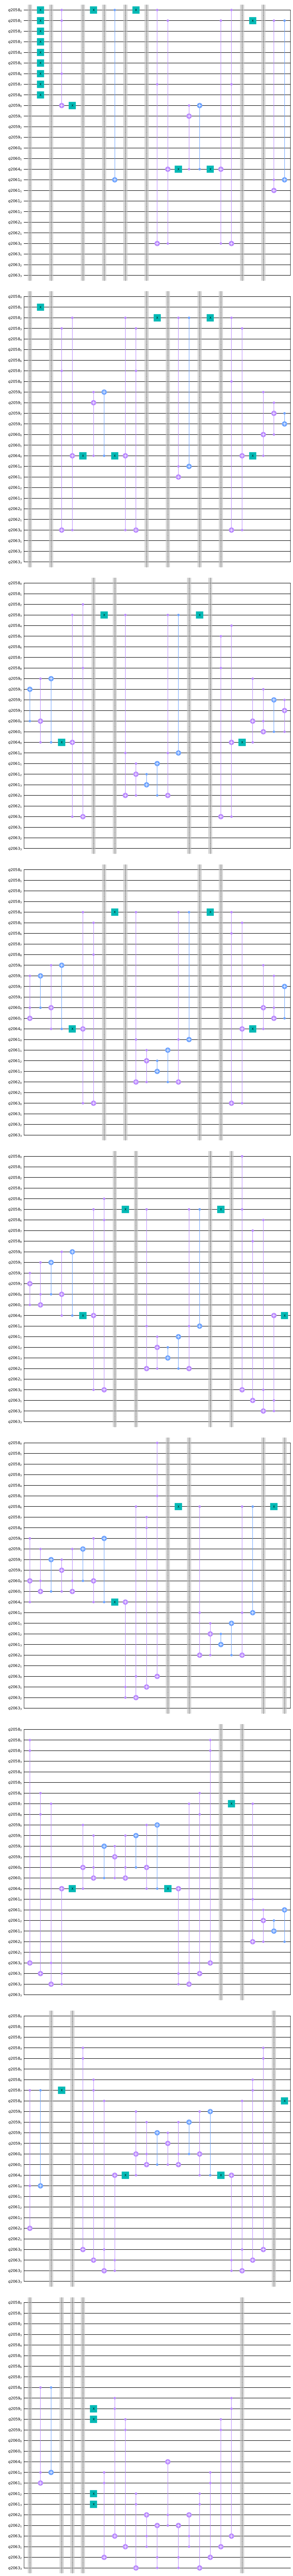

In [81]:
oracle_circ.draw('mpl')

Jeśli Twoje rozwiązanie zostało zaakceptowane przez nasz weryfikator, stwórz i prześlij plik zgłoszeniowy **razem z tym notebookiem uzupełnionym o Twoje rozwiązanie wraz z komentarzami** (łącznie dwa pliki). Z Twoich komentarzy powinno być jasne jak działa Twoje rozwiązanie. Upewnij się, że w `twoje_id` poniżej podałeś/aś swój poprawny identyfikator!

Zgłoszeń można dokonać [tutaj](https://ibm.ent.box.com/f/4c9101c0616f4897920a02a67d077321).

In [25]:
twoje_id = "08b02e61b7"
create_submission(qcirc, result, twoje_id)

Wygenerowaliśmy plik do wysłania o nazwie: zgloszenie_konkursowe.json. Nie zapomnij wysłać notebooka z rozwiązaniem!
